# HarvestStat Data Profiling - Burkina Faso

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32630' # Burkina Faso
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/BF_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Burkina Faso',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1984	 | BF1984A1 | 30	| nan	| 0	| nan	| 0	|
| 1997	 | BF1997A1 | 45	| nan	| 0	| nan	| 0	|
| 2001	 | BF2001A1 | 13	| BF2001A2	| 45	| nan	| 0	|
| 2020	 | BF2020A1 | 13	| BF2020A2	| 45	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# 2. Manual setting
# a) Add admin names to reporting units
admin_level = 'admin_2'
reporting_unit = df.loc[df['fnid'].map(lambda x: x[6] != 'A'), 'fnid'].unique()
df.loc[df.fnid.isin(reporting_unit),admin_level] = df.loc[df.fnid.isin(reporting_unit), 'locality_name'].map(lambda x: x.split(' ')[0])
# Remove duplicates (should be reported; found at 240416)
rdx = (df['fnid'] == 'BF2001A20803') & (df['season_year'].isin(['Main 2018', 'Main 2017']) & (df['product'] == 'Cowpea (unspecified)'))
df = df.loc[~rdx].reset_index(drop=True)
# ----------------------------------------------- #

# Temporal modification ------------------------- #
# We map the FNID of 1984 to 1997 until the data is updated
temp_1984 = BF_Admin1_1984[['FNID','ADMIN1','ADMIN2']].drop_duplicates()
temp_1997 = BF_Admin1_1997[['FNID','ADMIN1','ADMIN2']].drop_duplicates()
temp = temp_1984.merge(temp_1997, on='ADMIN1', how='inner', indicator=True)
fnid_dict = dict(zip(temp['FNID_x'], temp['FNID_y']))
df['fnid'] = df['fnid'].replace(fnid_dict)
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([BF_Admin1_1984, BF_Admin1_1997, BF_Admin2_2001, BF_Admin2_2020], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 69,236
Removed 23,142 "Missing Value" points
0/17,309 "Area Harvested" points are retained.
15,540/17,309 "Area Planted" points are retained.
15,352/17,309 "Quantity Produced" points are retained.
15,202/17,309 "Yield" points are retained.
Current data points: 46,094

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1984 - 2022
15 grain types are found: Bambara groundnut, Cotton (Unspecified), Cowpea (unspecified), Fonio, Groundnuts (In Shell), Maize (Corn), Millet, Potato (unspecified), Rice (Paddy), Sesame Seed, Sorghum, Sorghum (Red), Soybean (unspecified), Sweet Potatoes, Yams
2 seasons are found: Main (04-01), Annual (12-01)
4 crop production system are found: Rainfed (PS), All (PS), Plaine/Bas-fond irrigated (PS), Bas-fonds rainfed (PS)
Data sources include:
[1] INSD, Burkina Faso --- Official agricultural statistics, Burkina Faso
[2] Ministry o

- Burkina Faso crop seasonal calendar

<img src="../figures/crop_calendar/seasonal-calendar-burkina-faso.png" width=900>

- FDW data consists of `BF1984A1` and `BF2001A2`.

| Year  | Admin-1  | # units  | Admin-2  | # units |
| :---: | :----:   | :----:   | :----:   | :---:   |
| 1984  | **`BF1984A1`** | 30 | -        | -       |
| 1997  | BF1997A1 | 45       | -        | -       |
| 2001  | BF2001A1 | 13       | BF2001A2 | 45     |
| 2020  | BF2020A1 | 13       | **`BF2020A2`** | 45     |

- Comparison between admin boundaries.

<img src="../figures/BF_admin_shapes.png"  width=900>

- In 1997, 15 districts are divided and added.

| 1984-1997|1997-present|
| :---:|:---:|
|BF1984A161 (Bougouriba) | BF2001A21301 (Bougouriba), BF2001A21302 (loba)|
|BF1984A163 (Comoe) | BF2001A20201 (Comoe), BF2001A20202 (Leraba)|
|BF1984A164 (Gourma) | BF2001A20802 (Gourma), BF2001A20803 (Komondjari), BF2001A20804 (Kompienga), BF2001A20402 (Koulpelogo)|
|BF1984A165 (Houet) | BF2001A20901 (Houet), BF2001A20903 (Tuy)|
|BF1984A168 (Kossi) | BF2001A20103 (Kossi), BF2001A20102 (Banwa)|
|BF1984A169 (Mouhoun) | BF2001A20104 (Mouhoun), BF2001A20101 (Bale)|
|BF1984A170 (Oubritenga) | BF2001A21103 (Oubritenga), BF2001A21102 (Kourweogo)|
|BF1984A171 (Poni) | BF2001A21304 (Poni), BF2001A21303 (Noumbiel)|
|BF1984A172 (Seno) | BF2001A21202 (Seno), BF2001A21204 (Yagha)|
|BF1984A173 (Sissili) | BF2001A20603 (Sissili), BF2001A20604 (Ziro)|
|BF1984A174 (Sourou) | BF2001A20106 (Sourou), BF2001A20105 (Nayala)|
|BF1984A175 (Yatenga) | BF2001A21003 (Yatenga), BF2001A21001 (Loroum), BF2001A21004 (Zondoma)|

- In 2001, Admin-1 level became Admin-2 level (no name changes).
- **`BF2020A2`** is used to represent the current admin-level 2 crop data.
- Burkina Faso has a single crop season: `Main (04-01)`, `Annual (12-01)`
- Burkina Faso has 4 crop_production_system: `All (PS)`, `Rainfed (PS)`, `Plaine/Bas-fond irrigated (PS)`, `Bas-fonds rainfed (PS)`
- Burkina Faso has no population group(s).

In [4]:
# Define the latest shapefile ------------------- #
shape_latest = BF_Admin2_2020.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

BF1997A147:	"Boulkiemde" (FDW) is changed to "Bulkiemde" (shapefile).
BF2001A20601:	"Boulkiemde" (FDW) is changed to "Bulkiemde" (shapefile).


In [5]:
# Link admin boundaries ------------------------- #
link_1997, over_1997 = FDW_PD_CreateAdminLink(BF_Admin1_1997, BF_Admin2_2020, 'ADMIN1', 'ADMIN2', prod, epsg)
link_2001, over_2001 = FDW_PD_CreateAdminLink(BF_Admin2_2001, BF_Admin2_2020, 'ADMIN2', 'ADMIN2', prod, epsg)
# Crop specific ratios
link_ratio_1997 = FDW_PD_RatioAdminLink(link_1997, prod, over_1997, mdx_pss)
link_ratio_2001 = FDW_PD_RatioAdminLink(link_2001, prod, over_2001, mdx_pss)
# Merge link_ratio
assert link_ratio_1997.keys() == link_ratio_2001.keys()
link_merged = [link_ratio_1997, link_ratio_2001]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {
    'Bambara groundnut':'Bambara groundnut',
    'Cotton (Unspecified)': 'Cotton',
    'Cowpea (unspecified)': 'Cowpea',
    'Fonio':'Fonio',
    'Groundnuts (In Shell)': 'Groundnuts (In Shell)',
    'Maize (Corn)':'Maize',
    'Millet':'Millet',
    'Potato (unspecified)': 'Potato',
    'Rice (Paddy)':'Rice',
    'Sesame Seed': 'Sesame Seed',
    'Sorghum':'Sorghum',
    'Sorghum (Red)': 'Sorghum (Red)',
    'Soybean (unspecified)': 'Soybean',
    'Sweet Potatoes': 'Sweet Potatoes',
    'Yams': 'Yams',
}
assert set(stack['product'].unique()) == set(product_category_custom.keys())
stack['product'] = stack['product'].replace(product_category_custom)
for f, r in link_ratio.items():
    mdx = pd.MultiIndex.from_frame(r.index.to_frame().reset_index(drop=True).replace(product_category_custom))
    r.index = mdx
    link_ratio[f] = r
# Calibration of crop calendar using External Crop Calendar (ECC)
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[ecc['country'] == 'Burkina Faso']
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

All [season_name, product, crop_production_system] are in the external crop calendar.


## Postprocessing outlier removal

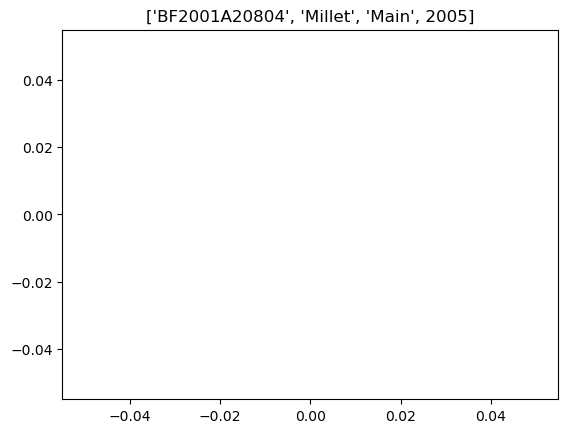

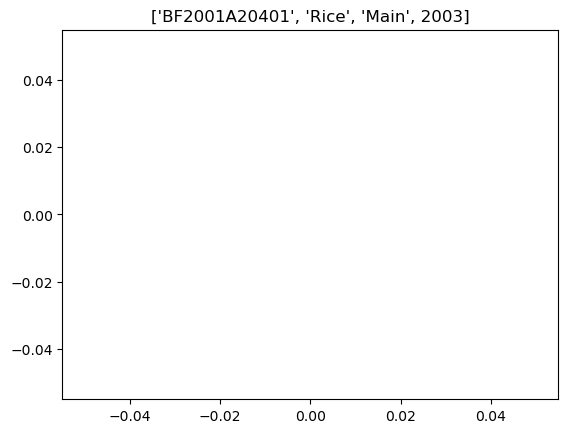

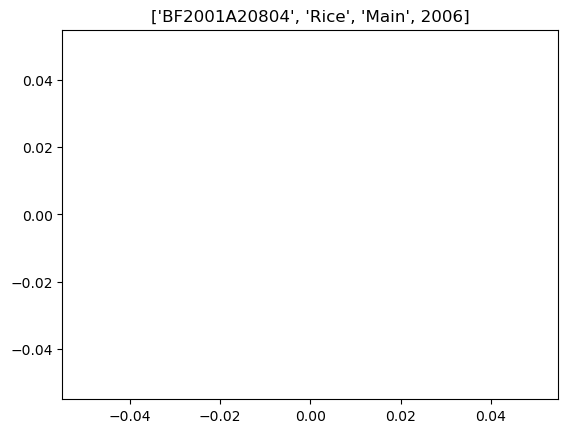

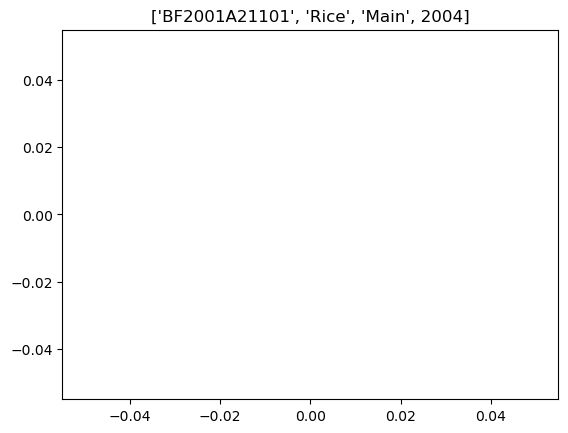

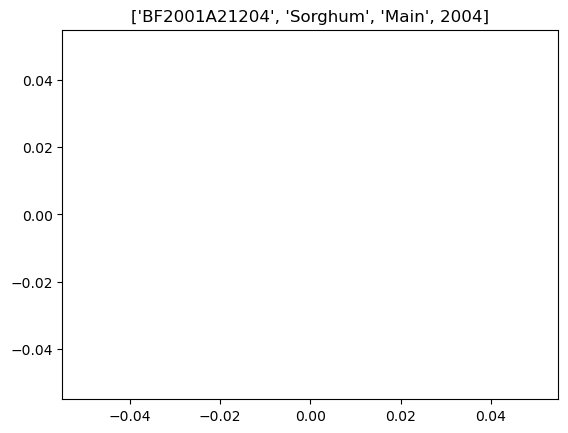

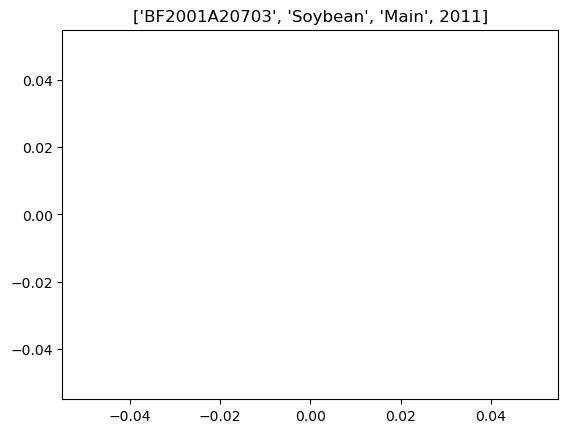

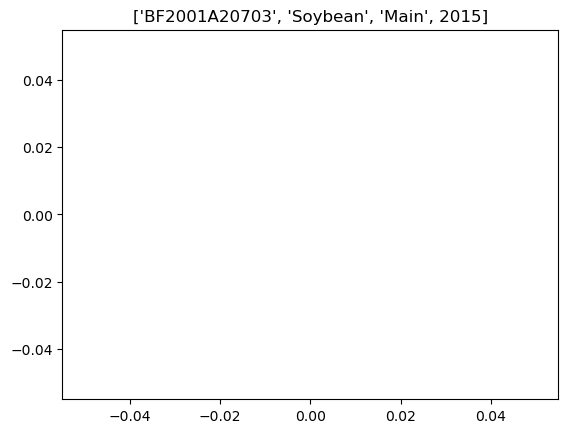

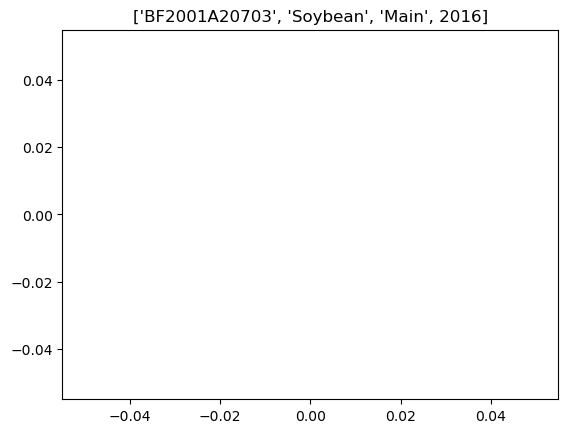

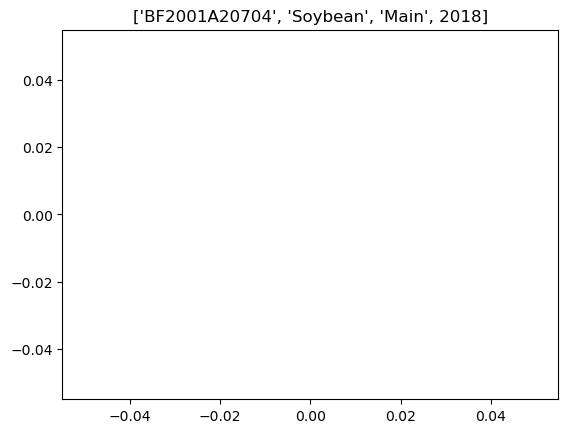

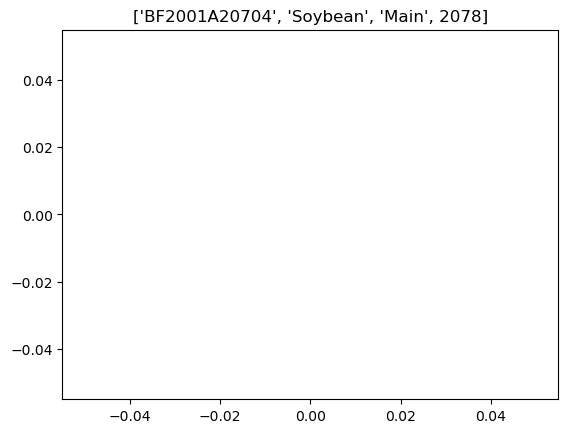

In [7]:
from matplotlib import pyplot as plt

outliers = [
            ['BF2001A20804','Millet','Main',2005],
            ['BF2001A20401','Rice','Main',2003],
            ['BF2001A20804','Rice','Main',2006],
            ['BF2001A21101','Rice','Main',2004],
            ['BF2001A21204','Sorghum','Main',2004],
            ['BF2001A20703','Soybean','Main',2011],
            ['BF2001A20703','Soybean','Main',2015],
            ['BF2001A20703','Soybean','Main',2016],
            ['BF2001A20704','Soybean','Main',2018],
            ['BF2001A20704','Soybean','Main',2078],
]
stack=stack.sort_values(by='harvest_year')

#first plot, then remove the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title(str(iou))
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1  

In [8]:
# Save data
fn_out = '../data/crop/adm_crop_production_BF.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_BF_ratio.npz', link_ratio)

../data/crop/adm_crop_production_BF.csv is saved.
../data/crop/adm_crop_production_BF_ratio.npz is saved.


# Visualization of production data

/Users/wanders7/Documents/Code/Project/NASA_GSCD/gscd/notebook/tools_graphic.py:433: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


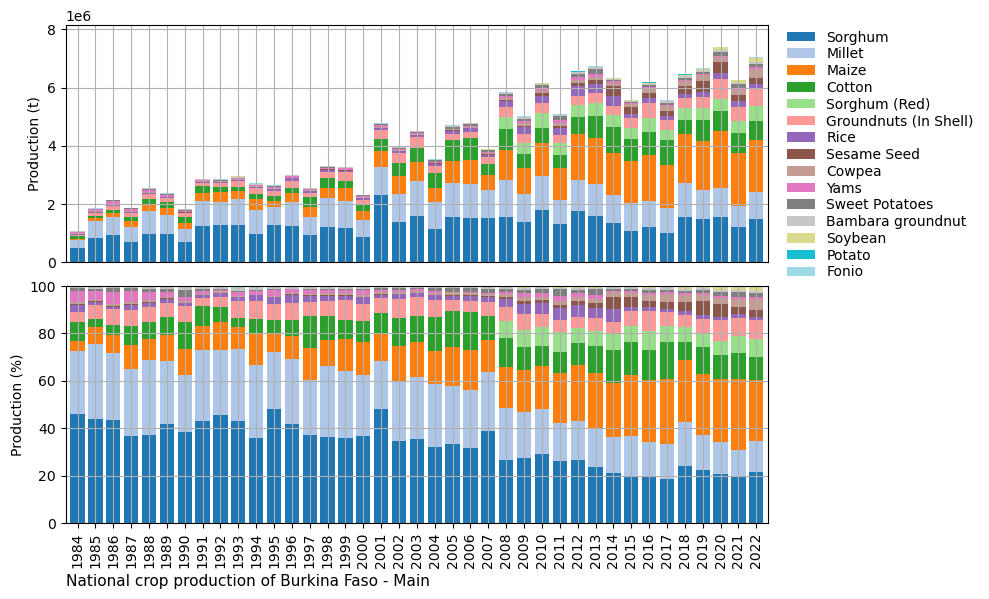

../figures/BF_bar_natgrainprod_Main.png is saved.


/Users/wanders7/Documents/Code/Project/NASA_GSCD/gscd/notebook/tools_graphic.py:433: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


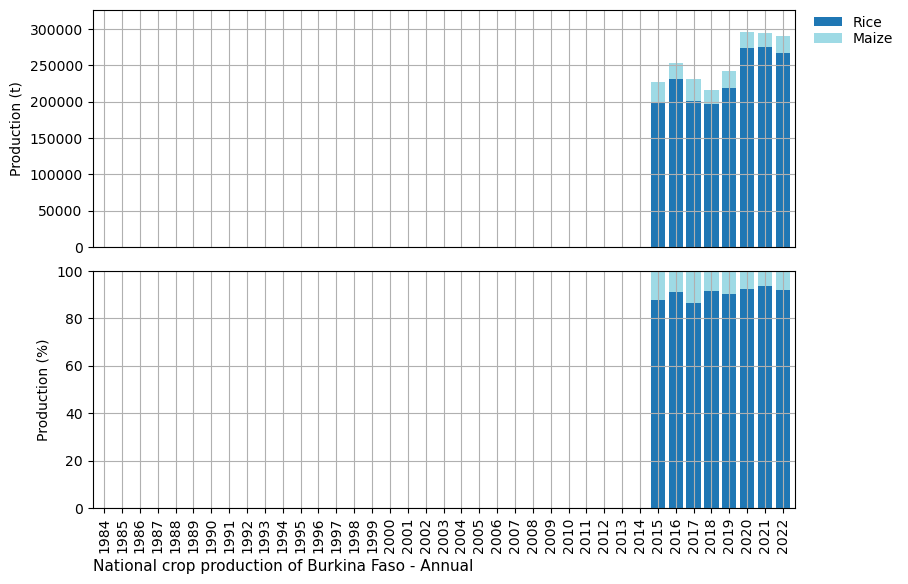

../figures/BF_bar_natgrainprod_Annual.png is saved.


In [9]:
# Bar chart of national crop production
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main','Annual']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

TypeError: pointplot() got an unexpected keyword argument 'linewidth'

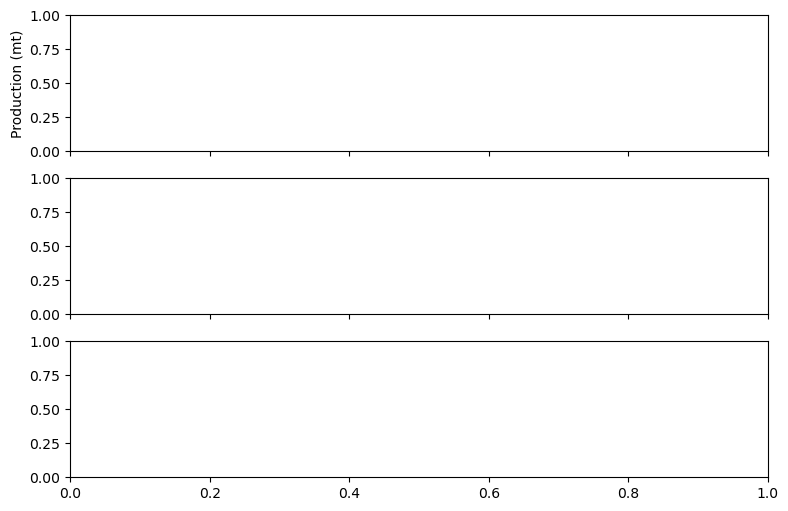

In [10]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Sorghum','Main'],
    ['Millet','Main'],
    ['Maize','Main']
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)